# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**\
**Auxiliar: Rodrigo Lara M**

**12/07/2020 - Tarea 2**


**Integrantes del grupo**: Fabián Badilla M., Francisco Vásquez L., Javier Santibáñez M.

# Sección nueva

## Introducción

La siguiente evaluación corresponde a la segunda tarea del curso de laboratorio de ciencia de datos. A lo largo de la tarea se trabaja sobre un problema de clasificación binaria de imágenes torácicas de rayos X, buscando predecir si la imagen corresponde a neumonía.

Se evaluará la presentación de sus resultados por medio de un informe, las condiciones de entrega requeridas son:
* La extensión máxima del informe es de 8 planas a las que puede añadir 2 para anexos.
* Debe adjuntar un repositorio ``git`` donde se incluya todo su código.
    * A lo menos 1 ``commit`` por cada pregunta de la tarea
    * Por lo menos 1 ``merge`` a través de su trabajo.
* Incluya un documento ``jupyter notebook`` llamado ``tarea2.ipynb`` en el cual se exponga todo el procedimiento realizado.
* Por  ́ultimo es necesario también entregar un archivo *hdf* denominado ``modelo.h5`` que contenga los pesos del mejor modelo de red neuronal obtenido.

Tenga  en  mente  que  su  informe  será  revisado  por  un  equipo  técnico  que  debe  entender  a  cabalidad  su metodología, ser capaz de replicarlo y evaluarlo a partir de su lectura.

## P1. Carga y transformación de datos

Al abordar un problema de clasificación de imágenes con redes neuronales profundas, es importante optimizar el proceso de carga de datos. Al tratarse de imágenes, es de esperar que no todas las muestras puedan ser almacenadas en memoria de manera simultanea, por lo que es necesario construir un *generador*. El objetivo de la sección es construir un *generador* de muestras eficiente, que minimice el tiempo de carga de datos y optimice el uso de memoria.

El conjunto de datos a utilizar está disponible en este [link](https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip). En la Figura 1 se observan algunas muestras de cada clase. La carpeta ``train`` consta de alrededor de $5.000$ imágenes y la carpeta ``test``, cerca de $600$. Al ser un conjunto de datos pequeño, se emplean técnicas de aumentación de datos que serán detalladas a continuación.

1. Instancie objetos de la clase ``torchvision.datasets.DataFolder`` que le permitan cargar las imágenes de las carpetas ``train`` y ``test``. Además, Construya la función ``loader``, que permite cargar muestras de la base de datos. En el parámetro ``transform``, instancie un objeto de la clase ``torchvision.transforms.Compose`` que componga las siguientes transformaciones:
    * Escalamiento de la imagen a un tamaño de $224\times 224$ pixeles. Además escale los valores de brillo delos pixeles a valores entre $0$ y $1$, dividiendo por el valor máximo del tipo de dato ``uint8``
    * Con probabilidad $\frac{1}{2}$, voltee la imagen en el eje horizontal.
    * Rote la imagen, con respecto a su centro, con un ángulo aleatorio entre -$20°$ y $20°$.
    * Multiplique los valores de brillo de cada canal por un número aleatorio entre $1,2$ y $1,5$. Cada pixel debeser multiplicado por un número potencialmente distinto, es decir, a cada valor de brillo corresponde un número aleatorio potencialmente diferente.

Mediante perfilamiento de tiempo de cómputo seleccione las herramientas que le parezcan óptimas para implementar las transformaciones anteriores. Puede utilizar las librerías ``pytorch``, ``PIL``, ``skimage`` u ``opencv``. Incluya en el reporte, una comparación con herramientas de 2 procesamientos de su elección.

**Observación:**  Se  recomienda  realizar  por  completo  las  secciones **P1** y **P2** antes de fundamentar su selección.

2. Visualice la cantidad de muestras de cada clase en las carpetas ``train`` y ``test``. Discuta sobre las implicancias de estas distribuciones.

Debido a que el balance de clases es diferente entre la carpeta ``train`` de la carpeta ``test``, es necesario definir cual es la distribución de clases del *problema*. En lo que sigue, asumiremos que dicha distribución es la que presenta la carpeta ``test``. Esto quiere decir que en un entorno de producción, se espera recibir muestras distribuidas de manera similar a tal conjunto, que llamaremos *conjunto de prueba*.

3. Separe los índices del objeto ``DataFolder`` de la carpeta ``train`` en un *conjunto de entrenamiento* y un *conjunto de validación*, con un $80$ y $20\%$ de las muestras respectivamente. Construya la clase ``ReplicarMuestreoDePrueba`` que herede de ``torch.utils.data.Sampler`` y permita iterar sobre el conjunto de validación de tal forma que replique la distribución de clases del *conjunto de prueba*, mediante un sobremuestreo de la clase minoritaria. Esta clase debe poseer los métodos:
    * ``__init__(self, etiquetas_prueba, indices_val, etiquetas_val):`` que guarde como atributos las variables necesarias para generar el muestreo deseado.
    * ``__iter__(self):`` que entregue un ``iterator`` sobre los índices del muestreo deseado
    
*Hint:* Puede ser útil emplear ``numpy.random.choice``. Observe que tendrá índices de validación duplicados.

**Observación:** Asuma que se trata de un problema de clasificación binaria.

4. Instancie objetos de la clase ``torch.utils.data.DataLoader`` para recorrer sus conjuntos de entrenamiento, validación y prueba. Para ello utilice los objetos adecuados en el parámetro ``sampler``. Discuta en el reporte las implicancias en tiempos de cómputo del parámetro ``num_workers``

*Hint:* Puede ser útil usar la clase ``torch.utils.data.sampler.SubsetRandomSampler`` para el *conjunto de entrenamiento* y ``torch.utils.data.RandomSampler`` para el *conjunto de prueba*.

**Observación:** Se recomienda realizar por completo las secciones **P1** y **P2** para fundamentar su discusión. Además, como referencia, en ``Colaboratory`` el parámetro ``batch_size=16`` es compatible con los recursos de la plataforma

## P2. Redes convolucionales profundas

El objetivo de esta sección es construir una red neuronal profunda para el problema de clasificación de imágenes de rayos X sobre neumonía. Dicha red debe ser implementada en ``Pytorch``.

<img src="https://miro.medium.com/max/1400/1*yG6z6ESzsRW-9q5F_neOsg.png" alt="drawing" style="width:600px;" title="(a) Capa de convolución depthwise"/>
<img src="https://miro.medium.com/max/1400/1*Q7a20gyuunpJzXGnWayUDQ.png" alt="drawing" style="width:600px;" title="(b) Capa de convolución pointwise"/>

<center>Figura 2: Componentes de la capa de convolución <em>Depthwise Separable Convolution</em></center>


Se implementa un tipo de capa de convolución conocida como *Dephtwise Separable Convolution*. Esta consiste en separar una capa de $k$ filtros de convolución de tamaño $n\times n$, i.e. definida por $k$ filtros de tamaño $n\times n\times c$ (donde $c$ representa el número de canales) en dos capas de convolución:

* Una capa de convolución llamada *Depthwise*, definida por $c$ filtros de tamaño $n\times n\times 1$, donde cada canal de entrada es convolucionado con su respectivo filtro, obteniéndose así un volumen de salida de $c$ canales. En la figura 2a se ilustra lo mencionado para $n= 5$, $c= 3$ y un $stride= 1$.


* Una capa de convolución llamada *pointwise*, definida por $k$ filtros de tamaño $1\times 1\times c$ que se aplica al volumen de salida de la capa *depthwise*. En la figura 2b se muestra su funcionamiento para $c= 3$ y $k= 256$. Cabe notar que la función de activación se aplica sólo en el volumen de salida de esta capa.


1. Construya la clase ``deDWSepConv2d`` que herede de ``torch.nn`` y haga overriding de los métodos ``__init__`` y ``forward``.  El  primero  debe  recibir  como  parámetros: ``in_channels``, ``out_channels``, ``kernel_size``, ``padding``, ``bias=True``. Estos tienen el significado usual empleados en los módulos ``torch.nn``.

*Hint:* Observe que para el ejemplo de la Figura 2 los parámetros tomarían los valores ``in_channels=3``, ``out_channels=256`` y ``kernel_size=5``.

2. Construya una red convolucional profunda mediante la clase ``VGG16DWSep`` que hereda ``torch.nn`` y hace overriding de los métodos ``__init__`` y ``forward``, de tal manera que la red posea la estructura detallada en la Tabla 1.  
  
  Obtenga el número de parámetros que tiene esta estructura y el número de parámetros que habrían sido utilizados si todas las capas ``DWSepConv2d`` hubiesen sido ``Conv2d``. Discuta la ganancia en tiempo de cómputo en entrenamiento y prueba.

3. Transfiera los pesos de las dos primeras capas de convolución de la red ``VGG16`` preentrenada en *imageNet* a las dos primeras capas de la red ``VGG16DWSep`` construida y manténgalos constantes durante el entrenamiento.

|     capa    | tamaño filtro | padding | stride | # filtros |
|:-----------:|:-------------:|:-------:|:------:|:---------:|
|    Conv2d   |       3       |    1    |    1   |     64    |
|    Conv2d   |       3       |    1    |    1   |     64    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    128    |
| DWSepConv2d |       3       |    1    |    1   |    128    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    256    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    256    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    256    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    512    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    512    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    512    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
|   Flatten   |       -       |    -    |    -   |     -     |
|    Linear   |       -       |    -    |    -   |    1024   |
| Dropout(.7) |       -       |    -    |    -   |     -     |
|    Linear   |       -       |    -    |    -   |    512    |
| Dropout(.5) |       -       |    -    |    -   |     -     |
|    Linear   |       -       |    -    |    -   |     2     |

  
  <center>Tabla 1: Estructura de la red VGG16DWSep</center>

Al entrenar redes neuronales profundas, es usual emplear una heurística de regularización llamada *Early Stopping* que consiste en monitorear alguna métrica de desempeño (usualmente la función de costo) en un conjunto de validación, para así detener el entrenamiento cuando dicha métrica empeora de forma sostenida.

En el siguiente fragmento de código ilustramos el uso de la heurística implementada en la clase ``EarlyStopping``:
```c
es = EarlyStopping (...)
for  epoch in range(num_epochs):
    # ciclo de entrenamiento
    ...

    # ciclo de validacion
    ...

    metrica_validacion = ...

    if es.deberia_parar(metrica_validacion):
        # se cumple el criterio de "early stop"
        break
```

<center>Listing 1: Funcionamiento de la heurística Early Stopping</center>

4. Programe la clase ``EarlyStopping``. Cuyo objetivo es implementar la heurística mencionada. Esta debe poseer los siguientes métodos:
    * ``__init__(self, modo=’min’, paciencia=5, porcentaje=False, tol=0):`` donde los parámetros:

        * ``modo``:  toma  valores  en ``’min’`` o ``’max’``.  Este  define  si  la  métrica  obtenida  en  el  conjunto de validación es considerada mejor al ser más pequeña o más grande según respectivamente.
        * ``paciencia``: define el número de épocas en la que la métrica de validación puede empeorar sin detener el entrenamiento.
        * ``porcentaje``: define si la comparación entre métricas de desempeño en validación, deben realizarse en términos relativos (como porcentaje de a la mejor métrica de desempeño observada) o absolutos.
        * ``tol``: define la diferencia mínima que debe existir con respecto la mejor métrica de desempeño observada en validación, para considerar si existe un empeoramiento del desempeño y actualizar el valor del contador asociado a ``paciencia``.
        
     Se deja a criterio del equipo la definición de atributos para el correcto funcionamiento de la clase.  
       
 * ``mejor(self, metrica_validacion):`` que compare la ``metrica_validacion`` con la mejor métrica de desempeño ya observada.  Dicha comparación debe realizarse considerando los parámetros ``modo``, ``porcentaje`` y ``tol``, y debe retornar ``True`` o ``False``.
 * ``deberia_parar(self, metrica_validacion):`` que llame al método ``mejor`` y retorne ``True`` cuando la cantidad de épocas en que ``metrica_validacion`` empeora con respecto a la mejor. métrica de desempeño observada sea igual a ``paciencia``. En caso contrario retorna ``False``.

5. Implemente el ciclo de entrenamiento de la red ``VGG16DWSep`` utilizando una instancia de la clase ``EarlyStopping`` según el esquema de Listing 1 con sus parámetros por defecto y además vaya guardando los pesos del mejor modelo obtenido a través de las épocas. Para dicho ciclo de entrenamiento use:
    * *Entropía cruzada* como función de costo.
    * *Adam* cómo algoritmo de optimización, con parámetros ``lr=1e-4`` y ``weight_decay=1e-5``.
    
Reporte sus resultados en términos de *accuracy* y *f1-score*. Compruebe que obtiene resultados superiores a $,75$ y $,8$ respectivamente. *Hint:* Por la magnitud del problema se recomienda usar GPU. Recuerde que en ``Colaboratory`` tiene acceso gratuito a dicho recurso.

6. Implemente aumentación de datos en el conjunto de prueba: para una observación $x_i$, obtenga $d$ muestras $\{x^{(j)}_i\}^d_{j=1}$ para calcular la predicción $\hat{y}_i=argmax_{j=1,...,d}f(x^{(j)}_i)$, donde $f(\cdot)$ representa la probabilidad asociada la predicción de su red. Discuta si es correcto o no realizar esto y soporte su argumento con los resultados obtenidos en términos de *accuracy* y *f1-score*.

*Hint:* Puede ser útil implementar una clase que herede de ``torch.utils.data.Sampler`` y que reciba como parámetros la cantidad de muestras para una misma observación $x_i$.

## P3. Interpretabilidad

El objetivo de esta pregunta es que implemente un modelo auxiliar de interpretabilidad local sobre laspredicciones que genera una red neuronal. Esto consiste en generar perturbaciones sobre datos de entrada, con el fin de comprender la importancia de las variables en los procesos de predicción. Para ello deberá implementar el método LIME (**L**ocal**I**nterpretable**M**odel-**A**gnostic**E**xplanations).

### Desarrollo teórico
El procedimiento LIME consiste en una metodología diseñada para otorgar *interpretabilidad* a modelos de aprendizaje que suelen ser denotados como “caja negra”. Por interpretabilidad se entiende, la capacidad deestablecer relaciones claras entre las variables de un fenómeno y la respuesta que producen. LIME es “agnóstico en el modelo”, esto se refiere a que pueda ser utilizado para cualquier tipo de modelo de predicción.

La idea central de LIME consiste en aproximar localmente el comportamiento de un predictor, utilizando un modelo que sea interpretable como por ejemplo regresión lineal o arboles de decisión. En términos concretos, dada una instancia a predecir $x\in\mathbb{R}^d$ (dato de entrada), se utilizará un vector $x′\in\{0,1\}^{d'}$como representación interpretable. Se define así, una **explicación** cómo un modelo $g\in G$, donde $G$ corresponde a una familia de modelos potencialmente interpretable, el dominio de cada $g\in G$ será $\{0,1\}^{d'}$. Para asegurar que la aproximación buscada sea interpretable por un humano, se utiliza una medida  de complejidad $\Omega(g)$ sobre cada $g\in G$, considerando el grado de complejidad en contraposición a la interpretabilidad de un modelo.

Sea un modelo predictor $f:\mathbb{R}^d\to \mathbb{R}$, sea además $x\in\mathbb{R}^d$ en el conjunto de datos de entrada, y $x′\in\{0,1\}^{'d}$ su representación interpretable. Para $x$ se define $\pi_x(z'):\{0,1\}^{'d} \to\mathbb{R}$ como una medida de similitud entre $x′$ y $z′\in \{0,1\}^{′d}$. Finalmente, se define $L(f,g,\pi_x)$ en una vecindad inducida localmente por $\pi_x$. Para asegurar interpretabilidad y fidelidad local (asociada a $x$), la explicación producida por LIME se obtiene resolviendo la siguiente expresión:

\begin{equation}
\xi(x) = arg min_{g\in G}\mathcal{L}(f,g,\pi_x) + \Omega(g)
\label{eqn:1}  \tag{1}
\end{equation}

En esta pregunta, se utilizará regresión logística cómo familia de explicaciones $G$, es decir para cada $g\in G$ este será de la forma $g(x′) =\sigma(w_g\cdot x′)$. Cómo función de fidelidad $\mathcal{L}$ se usa el la verosimilitud asociada a la regresión logística, ponderada localmente por $\pi_x$, es decir:

\begin{equation}
\mathcal{L}(f,g,\pi_x) =\sum_{z,z′}\pi_x(z)(f(z) log(g(z′)) + (1−f(z)) log(1−g(z′))
\label{eqn:2} \tag{2}
\end{equation}

En este caso $\pi_x$ será un kernel exponencial definido por una medida de similitud, se utilizará la distancia coseno:

\begin{align}
\pi_x(z′) &= \exp(−d(x′,z′)^2/\sigma^2)\tag{3} \\ 
d(x′,z′) &= 1−\frac{x′\cdot z′}{‖x′‖‖z′‖}
\label{eqn:4}\tag{4}
\end{align}

Implemente los paso iniciales para trabajos con LIME, para esto:
1. Instancie un objeto ``torchvision.transforms.Compose``, este opera sobre imágenes ``PIL`` y le aplique las siguientes transformaciones:
    * Escalamiento de la imagen a un tamaño de $229\times 229$ píxeles.
    * Opere por medio de ``CenterCrop(299)``.
    * Transforme la imagen en un objeto ``Tensor``.
    * Normalice con las medias ``[0.485, 0.456, 0.406]`` y, desviaciones estándar ``[0.229, 0.224, 0.225]``.

In [3]:
import torch
from PIL import Image
import torchvision.transforms as torch_transforms

In [4]:
# Se define la Media de la transformación
mean_transform = [0.485, 0.456, 0.406]
# std de la transformación
std_transform = [0.229, 0.224, 0.225]
# Número de center crops
n_centercrop = 299
# parámetros de escalamiento de la figura
x_resize = 299
y_resize = 299


# Se crea la 'pipeline' de un transformador de imagen cualquiera
image_transformer =  torch_transforms.Compose([
                                              torch_transforms.Resize((x_resize,y_resize)),
                                              torch_transforms.CenterCrop(n_centercrop),
                                              torch_transforms.ToTensor(),
                                              torch_transforms.Normalize(mean_transform, std_transform)
                                              ])

f_half_image_transformer =  torch_transforms.Compose([
                                              torch_transforms.Resize((x_resize,y_resize)),
                                              torch_transforms.CenterCrop(n_centercrop)
                                              ])

s_half_image_transformer =  torch_transforms.Compose([
                                              torch_transforms.ToTensor(),
                                              torch_transforms.Normalize(mean_transform, std_transform)
                                              ])

2. Cargue la red ``inception_v3`` entrenada sobre *imageNet* (en ``Pytorch``). Utilice esta red para hacer predicción sobre una imagen de control a la cual se aplican las transformaciones antes definidas. Obtenga la clase más probable asignada por la red. 

*Hint:* Puede ser ́útil la función ``decode_predictions``del módulo ``keras.applications.imagenet_utils`` sobre las predicciones de la red cargada.

In [5]:
# Definimos de primeras en qué device trabajaremos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torchvision.models as models

# Se carga la red entrenada inception_v3
model_inception = models.inception_v3( pretrained=True)

# Reactivamos la red
model_inception.eval()
model_inception.to(device)

In [7]:
from torchsummary import summary
summary(model_inception, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
       BasicConv2d-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 32, 109, 109]           9,216
       BatchNorm2d-5         [-1, 32, 109, 109]              64
       BasicConv2d-6         [-1, 32, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]          18,432
       BatchNorm2d-8         [-1, 64, 109, 109]             128
       BasicConv2d-9         [-1, 64, 109, 109]               0
           Conv2d-10           [-1, 80, 54, 54]           5,120
      BatchNorm2d-11           [-1, 80, 54, 54]             160
      BasicConv2d-12           [-1, 80, 54, 54]               0
           Conv2d-13          [-1, 192, 52, 52]         138,240
      BatchNorm2d-14          [-1, 192,

In [8]:
# Parámetros Generales para gráficos
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})      
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)  
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rcParams['axes.titlesize'] = 25
plt.rcParams["figure.figsize"] = (15,5)

In [9]:
# Funciones auxiliares

# Visualización de imágenes
def plot_image(image, title):
  fig, ax = plt.subplots()

  ax.imshow(image)
  ax.set_title(title, size = 20)
  ax.set_ylabel('Alto')
  ax.set_xlabel('Ancho')

def plot_multiple_images(vec_image, title = 'Plot Imagen Transformada'):
  fig, axs = plt.subplots(1, 3)
  for i in range(3):
    image = vec_image[i, :, :]
    axs[i].imshow(image)
    axs[i].set_title('Canal N°{}'.format(i+1))
  
  fig.suptitle(title)

def plot_multiple_images_control(image,vec_image):
  fig, axs = plt.subplots(1, 2, figsize = (8,4))
  for i in range(2):
    if i ==0:
      axs[i].imshow(image)
      axs[i].set_title('Imagen Original')
      axs[i].set_ylabel('Alto')
      axs[i].set_xlabel('Ancho')
    else:
      image = vec_image[i-1, :, :]
      axs[i].imshow(image)
      axs[i].set_title('Canal N°{} Tranformación'.format(i))
      axs[i].set_xlabel('Ancho')
  #fig.suptitle(title)
  plt.tight_layout()

Using TensorFlow backend.


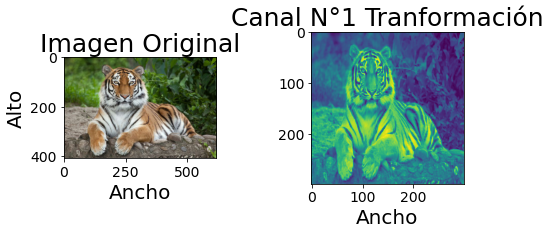

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import decode_predictions
from torch.autograd import Variable

# Fijamos la semilla
torch.manual_seed(1234)

'''
Las siguientes líneas comentadas son por si quieren cargar una imagen desde una
URL

# from io import BytesIO
# import requests

# url = 'https://farm4.static.flickr.com/3024/3003973173_765f89510b.jpg'
# image_url = requests.get(url)
# test_image_imagenet = Image.open(BytesIO(image_url.content))
'''

drive_path = 'data/images/'

image_path = drive_path + 'tiger_2.jpg'

# Se 'abre' la imagen
test_image = Image.open(image_path)

# Se aplica el transformador creado
test_image_transformed = image_transformer(test_image)

# Visualizamos la imagen y sus transformaciones
plot_multiple_images_control(test_image,test_image_transformed)
plt.savefig(drive_path + 'imagen_leon_transformaciones.pdf', format = 'pdf', dpi = 600)

In [11]:
# Generamos la predicción sobre la imagen
with torch.no_grad():
  test_image_transformed = test_image_transformed.to(device)
  pred_image = model_inception(test_image_transformed.unsqueeze(0))
  aux_pred = np.expand_dims(pred_image.cpu().detach().numpy(), axis=0)
  label_predict = decode_predictions(aux_pred[0])

In [12]:
# Mostramos los resultados 
label_predict

[[('n02129604', 'tiger', 9.209244),
  ('n02123159', 'tiger_cat', 7.7855873),
  ('n02127052', 'lynx', 2.4145942),
  ('n04266014', 'space_shuttle', 2.1141155),
  ('n02128925', 'jaguar', 1.9153283)]]

Notamos que el top 5 de los labels con más probabilidades acumulan aproximadamente un total de 23 porciento. Todos los labels son semejantes de cierta forma con el León, como lo son el tigre y el cheetah, felinos.

3. Segmente la imagen de control utilizando la función ``slic`` del módulo ``skimage.segmentation``, para los parámetros ``start_label=0``, ``n_segments=80``. El resultado de esta segmentación es un arreglo de dimensión $299\times 299$ que asigna una categoría para cada píxel de la imagen procesada. Todos los píxeles en la imagen que comparten etiqueta conforman un super-píxel dentro de la imagen. Utilice la función ``mark_boundaries`` del módulo ``skimage.segmentationen`` conjunción con ``imshow`` del módulo ``skimage.io`` para visualizar los bordes inducidos por el conjunto de super-píxeles.


In [13]:
# Lo primero es obtener de vuelta la imagen escalada desde los tensores
# Para poder aplicar slic

# 'Des-estandarizamos la imagen
im_reboot = test_image_transformed.cpu()*torch.tensor(std_transform).view(3,1,1)
im_reboot = im_reboot + torch.tensor(mean_transform).view(3,1,1)

# Transformamos la imagen a PIL
im_reboot = torch_transforms.ToPILImage(mode = 'RGB')(im_reboot)

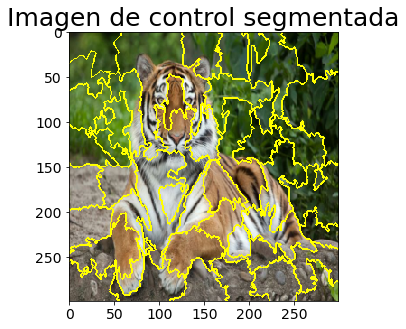

In [14]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import io

# Dividimos en 80 segmentos
n_segments = 80
start_label = 0

# Segmentamos la imágen
segmented_image =  slic(im_reboot, n_segments = n_segments) 

# Visualizamos la segmentación generadaplt
plt.subplots()
io.imshow(mark_boundaries(im_reboot, segmented_image))
plt.title('Imagen de control segmentada')
plt.show()

Al representar una imagen $x$ por medio de la presencia y ausencia de los super-píxeles se logra una representación interpretable $x′$ según un vector de entradas binarias.

Genere perturbaciones en la imagen de control, para esto siga los siguientes pasos:
4. Defina un número de *perturbaciones* a realizar (al menos $1,000$). Cada perturbación consiste en arreglo binario, donde cada componente es asociada a un super-píxel. Estos arreglos serán las representaciones interpretables de la imagen de control ($x′$ asociado a $x$). Considere cada entrada de su arreglo de perturbaciones como una variable aleatoria ``Bernoulli`` con $p= 0,5$.

In [15]:
from scipy.stats import bernoulli

# Fijamos la semillas para asegurar replicabiliadad
np.random.seed(1234)

# Definimos los parámetros a utilizar
p = 0.5
n_perturbaciones = 2000
n_superpixeles = len(np.unique(segmented_image))

# Creamos la matriz de perturbaciones 
matriz_perturbaciones = bernoulli.rvs(p,size = n_superpixeles * n_perturbaciones)
# Le damos la forma de matriz, donde cada columna representa un vector de 
# perturbaciones según el número de superpixeles de la imagen
matriz_perturbaciones = matriz_perturbaciones.reshape((n_superpixeles, n_perturbaciones))

5. Genere tantas versiones perturbadas de la imagen de control como perturbaciones haya construido. Obtener una imagen perturbada consiste en asignar el valor $0$ en cada canal de color en aquellos píxeles cuyos super-píxeles asociados tengan su componente nula en el vector de perturbaciones. Obtenga una visualización de una imagen perturbada.

In [16]:
def Generador_Pert_Images(image_path, n_iter, matriz_perturbaciones, 
                          slic_results, n_centercrop, f_half_image,
                          s_half_image, vgg = False):
  '''
  Generador de n_iter perturbaciones según una matriz_perturbaciones dada de una imagen

  image_path: PATH de carga de la imagen
  n_iter: Número de iteraciones
  matriz_perturbaciones: Matriz de perturbaciones 
  slic_results: resultados de alguna segmentacion de la imagen con .slic
  n_centercrop: valor de ancho de una imagen cuadrada (antes del typo era con centercrop)
  transformer: Transformador de imagens, torch.transforms.compose

  return: vector de imagenes en formato tensor
  '''
  vec_images = []
  if vgg:
    image = Image.open(image_path)
    img = image.split()
    if len(img) == 1:
        image = Image.merge('RGB', (img[0], img[0], img[0]))
    else:
        pass    
  else:
    image = Image.open(image_path)

  image = np.array(f_half_image(image))

  for i in range(n_iter):
    vec_images.append(np.copy(image))

  lista_indices = np.unique(slic_results)

  for i in range(n_iter):
    image = vec_images[i]
    vec_perturbaciones = matriz_perturbaciones[:, i]
    lista_pert = list(zip(*np.argwhere(vec_perturbaciones==0)))[0]
    a = np.copy(slic_results)
    for k in lista_indices:
      if k in lista_pert:
        a[a == k] = 0
      else:
        a[a == k] = 1
    a = np.repeat(a[:, :, np.newaxis], 3, axis=2)
    image = np.multiply(image, a)
    image = Image.fromarray(image.astype('uint8'), 'RGB')
          
    vec_images[i] = s_half_image(image)

  return(vec_images)

In [17]:
# Generamos el vector de transformaciones de la imagen de control
vec_images = Generador_Pert_Images(image_path,
                                   n_perturbaciones,
                                   matriz_perturbaciones,
                                   segmented_image,
                                   n_centercrop,
                                   f_half_image_transformer,
                                   s_half_image_transformer)

In [18]:

def plot_slic_image_vec(control_image, slic_control_image,
                        vec_image):
  # 'Des-estandarizamos la imagen
  rec_image = vec_image.cpu()*torch.tensor(std_transform).view(3,1,1)
  rec_image = rec_image + torch.tensor(mean_transform).view(3,1,1)

  # Transformamos la imagen a PIL
  rec_image = torch_transforms.ToPILImage(mode = 'RGB')(rec_image)
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (8,9))

  axs[0,0].imshow(control_image)
  axs[0,0].set_title('Imagen Original')
  axs[0,0].set_ylabel('Alto')

  axs[0,1].imshow(mark_boundaries(control_image, slic_control_image))
  axs[0,1].set_title('Segmentación')

  image = vec_image[0, :, :]
  axs[1,0].imshow(image)
  axs[1,0].set_title(' Trans. y Pert.')
  axs[1,0].set_xlabel('Ancho')
  axs[1,0].set_ylabel('Alto')

  axs[1,1].imshow(rec_image)
  axs[1,1].set_title('Perturbación')
  axs[1,1].set_xlabel('Ancho')
  plt.tight_layout()

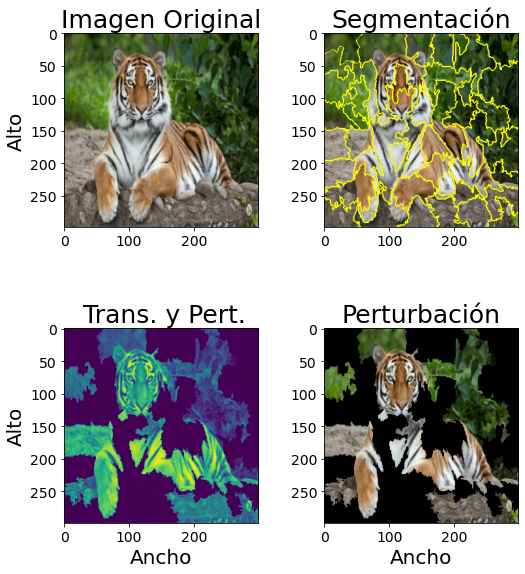

In [19]:
# Visualizamos la imagen segmentada y una perturbacion cualquiera
plot_slic_image_vec(im_reboot, segmented_image, vec_images[10])
plt.savefig(drive_path + 'leon_transformado_perturbado.pdf', format = 'pdf', dpi = 600)

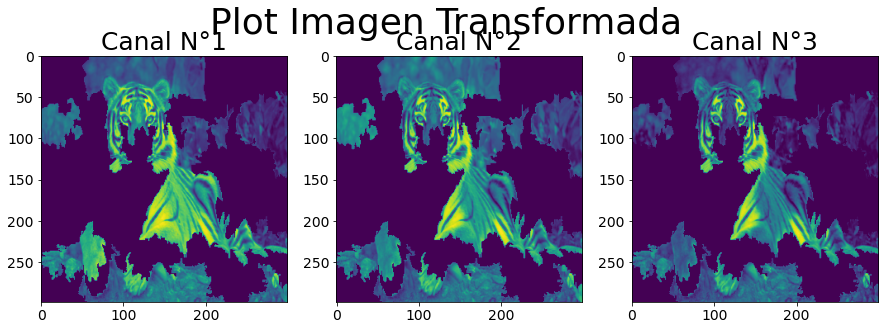

In [20]:
plot_multiple_images(vec_images[1000])

6. Haga predicción sobre las imágenes perturbadas utilizando la red ``inception_v3``. Asocie el valor $1$ como etiqueta a las imágenes perturbadas que sean clasificadas a la misma categoría de la imagen de control y $0$ en caso contrario, el arreglo binario correspondiente se denotará $y$.

In [21]:
def create_y_vector(unique_label, model, vec_images, vgg = False):
  # pred_inception = model(torch.from_numpy(vec_images))
  # Se muere la ram si hago lo anterior
  '''
  Función que crea el vector y

  unique_label: label único, string predecido
  model: modelo de red utilizado
  vec_images: vector de imágenes perturbada en formato tensor
  vgg: si es true, indica que el modelo es correspondiente a la Red VGG
  
  return:
  array de 1,0
  '''
  y_vec = []
  with torch.no_grad():
    for i in range(n_perturbaciones):
      if vgg:
        pred_image_v = model(vec_images[i].to(device).unsqueeze(0))
        aux_pred_v = np.expand_dims(pred_image_v.cpu().detach().numpy(), axis=0)
        y_vec.append(np.argmax(np.array(aux_pred_v)[0][0]))
      else:     
        #pred_inception  = model(torch.from_numpy(vec_images[i]).to(device).unsqueeze(0))
        pred_inception  = model(vec_images[i].to(device).unsqueeze(0))
        labels_prediction = decode_predictions(pred_inception.cpu().detach().numpy(), top = 1)
        label_pred = labels_prediction[0][0][1]
        y_vec.append(int(unique_label == label_pred))
        #y_vec.append(label_pred)
  return np.array(y_vec)

In [22]:
# Creamos el vector solicitado
y = create_y_vector(label_predict[0][0][1], model_inception, vec_images)

In [23]:
import pandas as pd

# Realizamos un conteo de los casos positivos y negativos
pd.Series(y).value_counts()

1    1409
0     591
dtype: int64

Notamos que las clases encontradas no se encuentran en un gran desbalanceo. Con las perturbaciones se predijo un total de 374 veces 'bien' la imagen. 

7. Calcule $\pi_x$ según la expresión **(3)**. Para ello, obtenga la distancia de coseno entre las perturbaciones asociadas a cada imagen perturbada y el vector de perturbación de la imagen de control $x$ según lo indica **(4)**.

In [24]:
sigma = 0.25

def pi_x(x,z):
  dxz = 1 - (x@z)/((np.sqrt(x@x))*(np.sqrt(z@z)))
  return np.exp(- dxz/sigma)

In [25]:
def create_pi_vector(n_superpixeles, matriz_perturbaciones):
  x = np.ones((n_superpixeles))
  vec_pi_x = []
  for i in range(n_perturbaciones):
    z = matriz_perturbaciones[:, i]
    vec_pi_x.append(pi_x(x,z))
  return vec_pi_x

In [26]:
vec_pi_x = create_pi_vector(n_superpixeles, matriz_perturbaciones)

Una vez obtenido un conjunto de representaciones para la imagen de control $x$ y el vector de pesos asociados $\pi_x$, se pasa a minimizar la función de fidelidad, para esto:
8. Genere un conjunto de entrenamiento $D_p$. Este consta de vectores de perturbación como observaciones. La variable de respuesta será el arreglo $y$ generado anteriormente.

In [27]:
# Este arreglo ya lo consideramos anteriormente en la parte P3.4
D_p = matriz_perturbaciones.T

9. Utilice la clase ``LogisticRegression`` del módulo ``sklearn.linearmodel`` para entrenar un clasificador sobre conjunto de entrenamiento $D_p$. Haga uso de $\pi_x$ al momento de utilizar el método ``.fit()``. ¿Es posible agregar una medida de complejidad $\Omega(g)$ con este esquema? argumente al respecto

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pandas as pd

def train_and_test_logreg(D_p, y, vec_pi):
  '''
  input:
  D_p: Conjunto de entrenamiento
  y: vector de labels 
  vec_pi: vector de pesos para D_p

  return:
  Modelo de regresión logística entrenado
  '''

  X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(D_p,
                                                    y,
                                                    vec_pi,
                                                    shuffle=True,
                                                    test_size = 0.2,
                                                    stratify = y)

  l_model = LogisticRegression()
  l_model.fit(X_train, y_train, sample_weight = sw_train)
  y_pred = l_model.predict(X_test)

  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred) 
  classes = unique_labels(y_test, y_pred)

  plt.figure(figsize = (5,5))

  g = sns.heatmap(pd.DataFrame(cm, index = classes, columns = classes),
                  annot=True, fmt = 'd', 
                  cmap="Blues")
  g.set_yticklabels(g.get_yticklabels(), rotation = 0)

  plt.title('Matriz de Confusión')
  plt.xlabel('Label Predecido')
  plt.ylabel('Label Real')

  return l_model


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       118
           1       0.93      0.93      0.93       282

    accuracy                           0.91       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.91      0.91      0.91       400



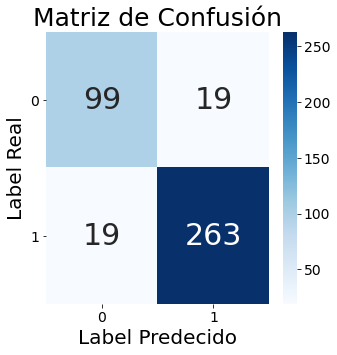

In [29]:
log_control = train_and_test_logreg(D_p, y, vec_pi_x)
#

10. Utilice los coeficientes del clasificador anterior para inferir los super-píxeles de mayor importancia en la clasificación de la imagen de control. Obtenga una visualización y discuta al respecto.

In [30]:
def evaluate_coefs(log_coefs, slic, to_save, vgg = False, vgg_image = None):
  '''
  Funcion que entrega los coeficientes más importantes según criterio de mean(abs) y 
  entrega la imagen correspondiente a los coeficientes más altos y más bajos
  '''
  segmento = range(1,len(log_coefs[0])+1)
  aux_df = pd.DataFrame({'val_coef':log_coefs[0]} , index = segmento)

  high_value_coef = aux_df.loc[aux_df.val_coef > np.mean(abs(aux_df.val_coef))].index
  low_value_coef = aux_df.nsmallest(5, 'val_coef').index

  fig,ax = plt.subplots(figsize = (12,8))
  aux_df.plot(kind = 'bar', ax = ax)
  plt.axhline(y=np.mean(abs(aux_df.val_coef)), color='r', linestyle='-')
  ax.tick_params(axis = 'x', labelsize = 10)
  ax.set_ylabel('Valor_ Coef.')
  ax.set_xlabel('Segmento')
  plt.tight_layout()
  plt.savefig(drive_path + to_save + '.pdf', format = 'pdf', dpi = 600)
  plt.show()

  if vgg:
    image_coef = np.array(vgg_image)
  else:
    image_coef = np.array(im_reboot)

  im_best = np.copy(image_coef)
  im_worst = np.copy(image_coef)

  for j in range(image_coef.shape[0]):
    for k in range(image_coef.shape[1]):
      n_pix = slic[j,k]
      if n_pix not in high_value_coef:
        im_best[j,k] = [0, 0, 0]

  for j in range(image_coef.shape[0]):
    for k in range(image_coef.shape[1]):
      n_pix = slic[j,k]
      if n_pix not in low_value_coef:
        im_worst[j,k] = [0, 0, 0]

  print('El promedio de los abs de los coeficientes es de {:.2f}'.format(np.mean(abs(aux_df.val_coef))))

  return aux_df, im_best, im_worst

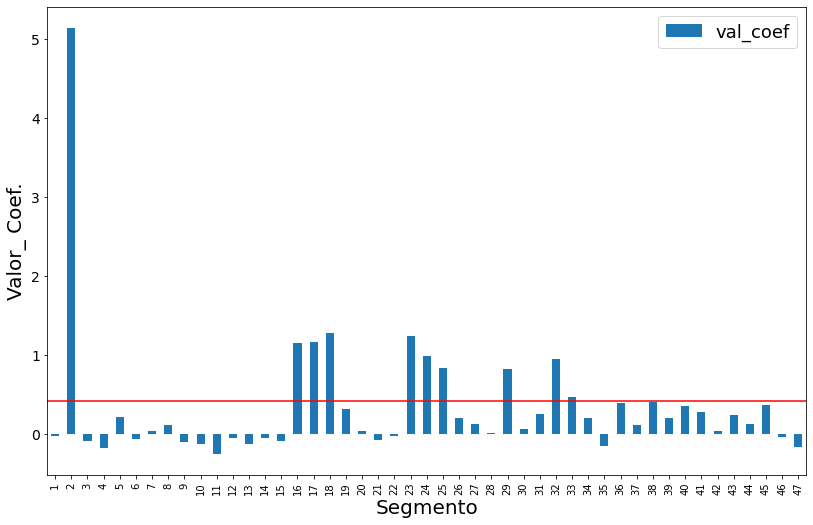

El promedio de los abs de los coeficientes es de 0.42


In [31]:
df_control, image_best_control, image_worst_control = evaluate_coefs(log_control.coef_, segmented_image,
                                                                     to_save = 'control_coefs')

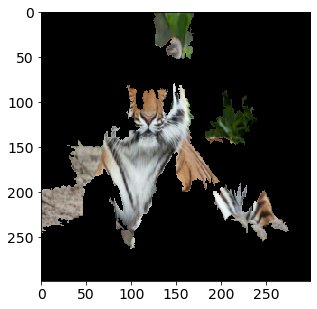

In [32]:
io.imshow(image_best_control)

La segmentación antes utilizada se hace de *manera espacial*. Es decir, se realiza una clusterización sobre la escala de grises según su posición en la imagen. Del procedimiento recién explicado para implementar LIME reemplace la etapa de segmentación de la imagen por 2 segmentaciones espaciales utilizando 2 modelos de clustering a su elección, para ello:
11. Clusterice sobre un conjunto de entrenamiento $X$ con $299^2$ observaciones, es decir, una observación por píxel en la imagen de control escalada. Cada observación de $X$ consta de 3 componentes, donde la primera y segunda son espaciales (posición del píxel en la imagen) y la última es el valor de intensidad asociado al píxel (escala de grises). Utilice los clusters descubiertos para generar super-píxeles.  
  
  *Hint:* En Scikit-learn el método ``fit_predict`` en algoritmos de clustering puede ser de ayuda para generar super-píxeles

Se seleccionaron los métodos de kmeans y GaussianMixture para la clusterización, esto debido a la cantidad de datos del problema, estos algoritmos escalan bien con el número de estos.

Lo primero a realizar es crear el dataset que se menciona

In [31]:
# Se convierte la imagen a escala de grises
gray_im = im_reboot.convert('L')

# Se pasa a un array
np_gray_im = np.array(gray_im)

# Se crea el dataframe con las indicaciones
# (posición x, posición y, número en escala de grises)
df_X = []
for i in range(299):
  for j in range(299):
    df_X.append([i, j, np_gray_im[i,j]])

df_X = np.array(df_X)

## K-Means
Se importa el modelo KMeans, además de métricas que nos ayudarán en la selección del número de clusters.

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

Se crean funciones auxiliares que nos permitirán escoger de mejor forma el número de clusters para kmeans. Se implementa el método del codo además del método de la Silueta.

In [33]:
# Rango de clusters a buscar
range_clusters_SSE = range(5,20)
range_clusters = range(5,20)

def SSE_AVGS(dataset):
    sse_kmeans = []
    vec_prom_kmeans=[]

    for k in range_clusters_SSE:
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(dataset)
        sse_kmeans.append(kmeans.inertia_)
        if k>=2:
            silhouette_avg = silhouette_score(dataset,
                                              kmeans.fit_predict(dataset) )
            vec_prom_kmeans.append(silhouette_avg)
    return sse_kmeans, vec_prom_kmeans


def FuncionPlot(sse, vec_prom):
    f, (ax1, ax2) = plt.subplots(1, 2)
    plt.figure(figsize = (15,10))

    ax2.plot(range_clusters_SSE, sse)
    ax1.set_xlabel('Número de Clusters')
    ax1.set_ylabel('Promedio Score Silueta')
    ax1.set_title('Promedio Score Silueta por K Clusters',
             fontsize = 20)

    ax1.plot(range_clusters, vec_prom)
    ax2.set_xlabel('Número de Clusters')
    ax2.set_ylabel('Valor SSE')
    ax2.set_title('Valor SSE por número de clusters',
             fontsize = 20)
    


In [34]:
# Demora mucho esto
#sse_im, avg_sil_im = SSE_AVGS(df_X)
#FuncionPlot(sse_im, avg_sil_im)

In [35]:
# clusters_image = range_clusters_SSE[np.argmax(avg_sil_im)]
n_clusters_kmeans = 17 # Buen número, sobre ese igual apaña

Se aplica el modelo Kmeans sobre el conjunto creado


In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = n_clusters_kmeans, random_state = 1).fit(df_X)

Se utilizan los labels obtenidos para etiquetar los datos (pixeles) para así obtener los superpixeles

In [37]:
df_X_kmeans = np.c_[df_X, kmeans.labels_]

In [38]:
def slic_model(df_X_model, n_centercrop):
  slic_model = np.zeros((n_centercrop,n_centercrop))

  for i in range(n_centercrop*n_centercrop):
      slic_model[df_X_model[i][0]][df_X_model[i][1]] = int(df_X_model[i][3])

  slic_model = slic_model.astype(int)
  return slic_model

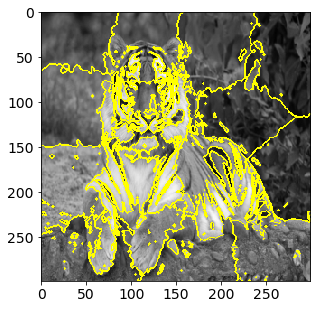

In [39]:
slic_kmeans = slic_model(df_X_kmeans, n_centercrop)
io.imshow(mark_boundaries(gray_im, slic_kmeans))

## Gaussian Mixture

se importa el modelo y, a priori, un número de componentes igual a 20

In [40]:
from sklearn.mixture import GaussianMixture

GM = GaussianMixture(n_components= 17).fit(df_X)

Se crea el dataset y las etiquetas de cada pixel

In [41]:
df_X_GM = np.c_[df_X, GM.predict(df_X)]

In [42]:
slic_GM = slic_model(df_X_GM, n_centercrop)

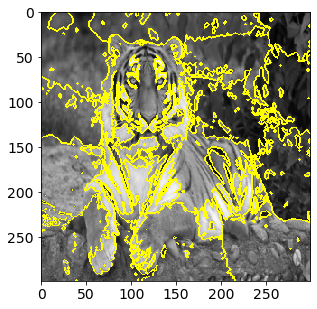

In [43]:
io.imshow(mark_boundaries(gray_im, slic_GM))

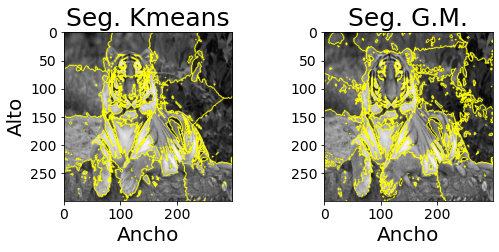

In [44]:
fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].imshow(mark_boundaries(gray_im, slic_kmeans))
axs[0].set_title('Seg. Kmeans')
axs[0].set_ylabel('Alto')
axs[0].set_xlabel('Ancho')

axs[1].imshow(mark_boundaries(gray_im, slic_GM))
axs[1].set_title('Seg. G.M.')
axs[1].set_xlabel('Ancho')
plt.tight_layout()
plt.savefig(drive_path + 'slic_segmentacion.pdf', format = 'pdf', dpi = 600)


  12. Aplique el esquema LIME desarrollado anteriormente sobre sus super-píxeles. Interprete los resultados

## Kmeans

In [45]:
# Creamos la matriz de perturbaciones 
matriz_perturbaciones_kmeans = bernoulli.rvs(p,size = n_clusters_kmeans * n_perturbaciones, random_state = 10)
# Le damos la forma de matriz, donde cada columna representa un vector de 
# perturbaciones según el número de superpixeles de la imagen
matriz_perturbaciones_kmeans = matriz_perturbaciones_kmeans.reshape((n_clusters_kmeans, n_perturbaciones))

In [46]:
vec_images_kmeans = Generador_Pert_Images(image_path, n_perturbaciones,
                                          matriz_perturbaciones_kmeans,
                                          slic_kmeans, n_centercrop,
                                          f_half_image_transformer,
                                          s_half_image_transformer)

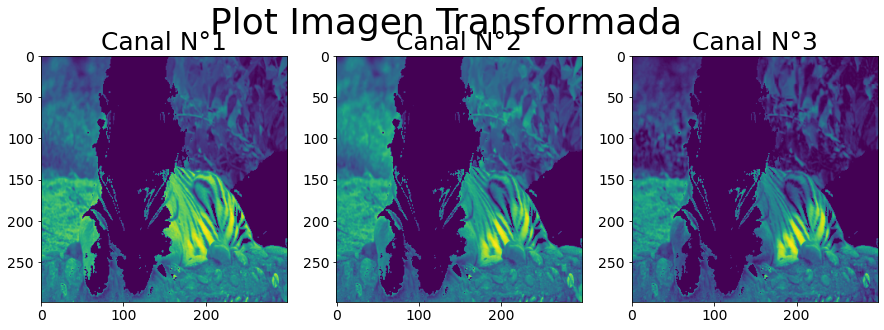

In [47]:
# Visualizamos lo obtenido
plot_multiple_images(vec_images_kmeans[10])

In [48]:
y_kmeans = create_y_vector(label_predict[0][0][1], model_inception, vec_images_kmeans)

In [49]:
# La cantidad de labels bien catalogados es de
pd.Series(y_kmeans).value_counts()

1    1738
0     262
dtype: int64

In [50]:
vec_pi_kmeans = create_pi_vector(n_clusters_kmeans, matriz_perturbaciones_kmeans)

In [51]:
D_p_kmeans = matriz_perturbaciones_kmeans.T

              precision    recall  f1-score   support

           0       0.86      0.58      0.69        52
           1       0.94      0.99      0.96       348

    accuracy                           0.93       400
   macro avg       0.90      0.78      0.83       400
weighted avg       0.93      0.93      0.93       400



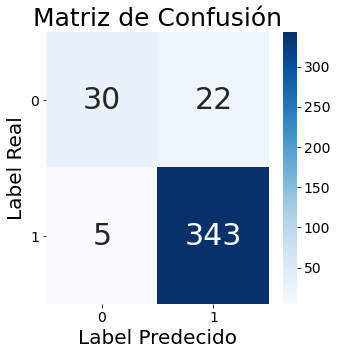

In [52]:
log_kmeans = train_and_test_logreg(D_p_kmeans, y_kmeans, vec_pi_kmeans)

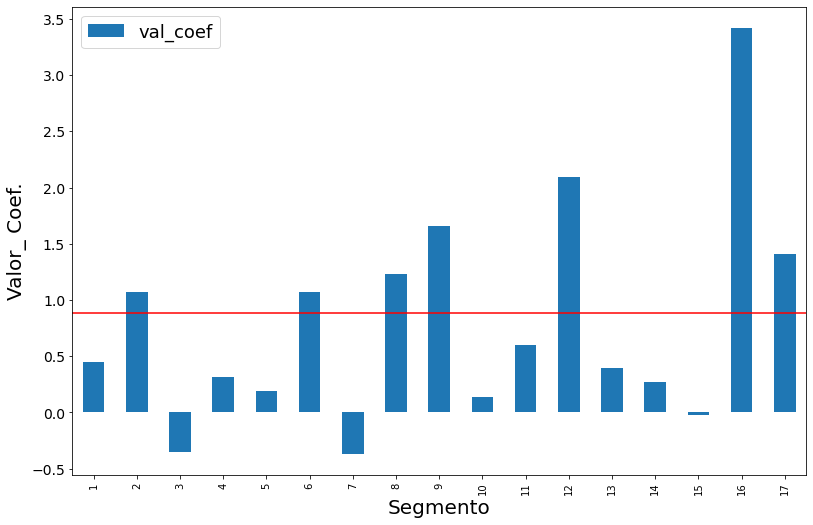

El promedio de los abs de los coeficientes es de 0.88


In [53]:
df_kmeans, seg_kmeans_image_best, seg_kmeans_image_worst = evaluate_coefs(log_kmeans.coef_, slic_kmeans,
                                                                          to_save = 'coef_kmeans')

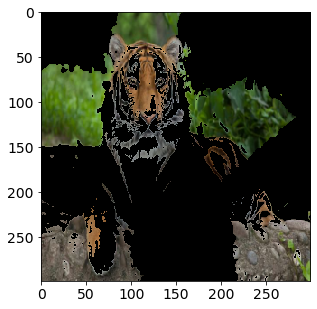

In [54]:
io.imshow(seg_kmeans_image_best)

## GM

In [55]:
n_clusters_GM = len(np.unique(slic_GM))

In [56]:
# Creamos la matriz de perturbaciones 
matriz_perturbaciones_GM = bernoulli.rvs(p,size = n_clusters_GM * n_perturbaciones)
# Le damos la forma de matriz, donde cada columna representa un vector de 
# perturbaciones según el número de superpixeles de la imagen
matriz_perturbaciones_GM = matriz_perturbaciones_GM.reshape((n_clusters_GM, n_perturbaciones))


In [57]:
vec_images_GM = Generador_Pert_Images(image_path, n_perturbaciones,
                                          matriz_perturbaciones_GM,
                                          slic_GM, n_centercrop,
                                      f_half_image_transformer,
                                          s_half_image_transformer)

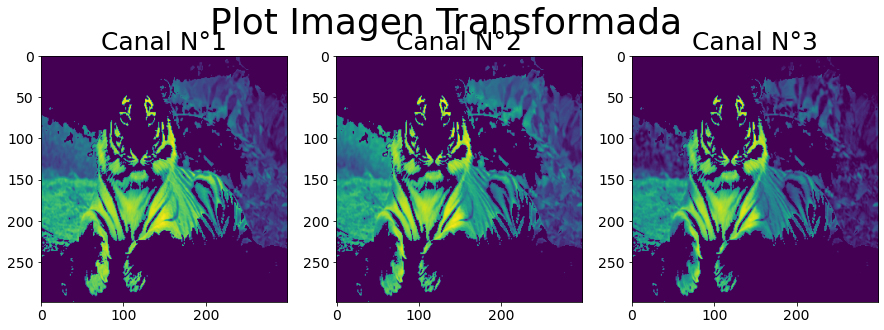

In [58]:
plot_multiple_images(vec_images_GM[10])

In [59]:
y_GM = create_y_vector(label_predict[0][0][1], model_inception, vec_images_GM)


In [60]:
# La cantidad de labels bien catalogados es de
pd.Series(y_GM).value_counts()

1    1716
0     284
dtype: int64

In [61]:
vec_pi_GM = create_pi_vector(n_clusters_GM, matriz_perturbaciones_GM)


In [62]:
D_p_GM = matriz_perturbaciones_GM.T

              precision    recall  f1-score   support

           0       0.96      0.81      0.88        57
           1       0.97      0.99      0.98       343

    accuracy                           0.97       400
   macro avg       0.96      0.90      0.93       400
weighted avg       0.97      0.97      0.97       400



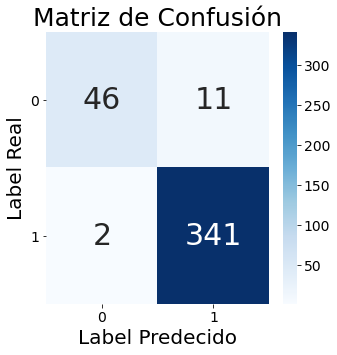

In [63]:
log_GM = train_and_test_logreg(D_p_GM, y_GM, vec_pi_GM)

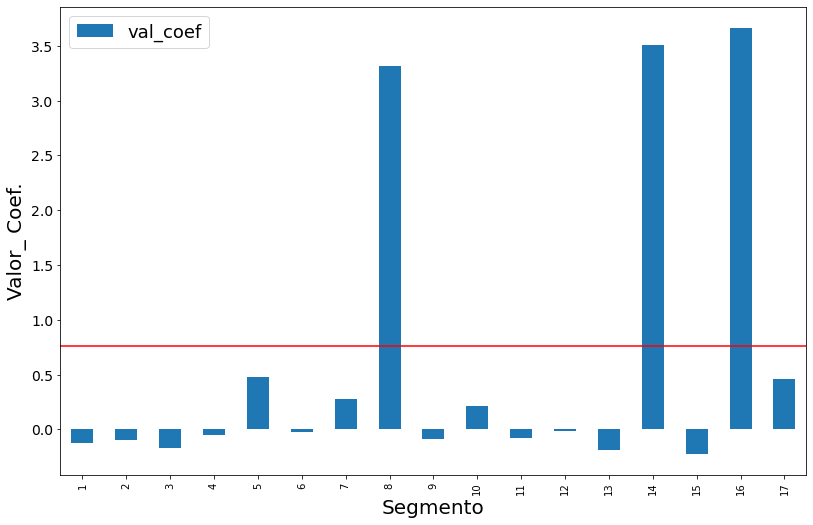

El promedio de los abs de los coeficientes es de 0.76


In [64]:
df_GM, seg_GM_image_best, seg_GM_image_worst = evaluate_coefs(log_GM.coef_, slic_GM,
                                                              to_save = 'coefs_GM')

## Comparación KMeans, GM

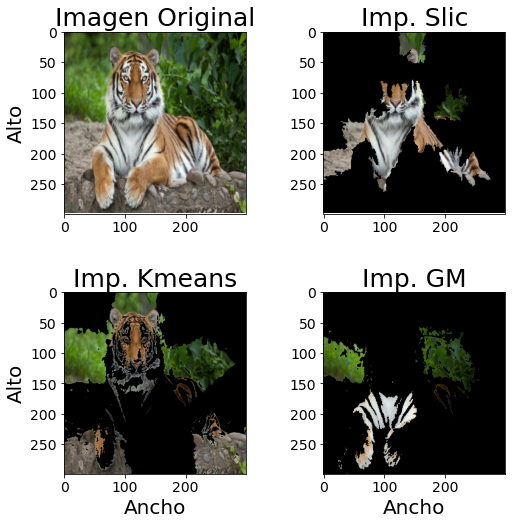

In [65]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (8,8))
axs[0,0].imshow(im_reboot)
axs[0,0].set_title('Imagen Original')
axs[0,0].set_ylabel('Alto')

#axs[0,1].imshow(mark_boundaries(image_coef_control, segmented_image))
axs[0,1].imshow(image_best_control)
axs[0,1].set_title('Imp. Slic')

#axs[1,0].imshow(mark_boundaries(seg_kmeans_image, slic_kmeans))
axs[1,0].imshow(seg_kmeans_image_best)
axs[1,0].set_title('Imp. Kmeans')
axs[1,0].set_xlabel('Ancho')
axs[1,0].set_ylabel('Alto')

#axs[1,1].imshow(mark_boundaries(seg_GM_image, slic_GM))
axs[1,1].imshow(seg_GM_image_best)
axs[1,1].set_title('Imp. GM')
axs[1,1].set_xlabel('Ancho')
plt.tight_layout()
plt.savefig(drive_path + 'importantes_general.pdf', format = 'pdf', dpi = 600)

In [66]:
df_control.loc[df_control.val_coef >np.mean(abs(df_control.val_coef))].shape

(10, 1)

In [67]:
df_GM.loc[df_GM.val_coef >np.mean(abs(df_GM.val_coef))].shape

(3, 1)

In [68]:
df_kmeans.loc[df_kmeans.val_coef >np.mean(abs(df_kmeans.val_coef))].shape

(7, 1)

#3 Aplicación LIME sobre VGG16DWSep

*Finalmente* aplique un esquema LIME sobre una predicción de la red ``VGG16DWSep`` implementada en la parte 2 de la tarea. Discuta sus resultados y observaciones

In [69]:
from torch import nn
import torch.nn.functional as F

In [70]:

class DWSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=1,groups=in_channels, padding=padding, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=1, bias=bias)
        
    def forward(self, x):
        x = self.depthwise(x.float())
        x = F.relu(self.pointwise(x))
        return x

In [71]:
class VGG16DWSep(nn.Module):
    """Red neuronal profunda VGG16 con separación Depthwise 
    descrita en la tabla 1 del enunciado"""
    def __init__(self):
        """Se hereda init y se definen todas las capas que participaran""" 
        super().__init__()
        self.dw1 = DWSepConv2d(64, 128, 3, 1)
        self.dw2 = DWSepConv2d(128,128, 3, 1)
        self.dw3 = DWSepConv2d(128,256, 3, 1)
        self.dw4 = DWSepConv2d(256,256, 3, 1)
        self.dw5 = DWSepConv2d(256,256, 3, 1)
        self.dw6 = DWSepConv2d(256,512, 3, 1)
        self.dw7 = DWSepConv2d(512,512, 3, 1)
        self.dw8 = DWSepConv2d(512,512, 3, 1)
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64,64, 3, stride=1, padding=1)
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bat1= nn.BatchNorm2d(256)
        self.bat2= nn.BatchNorm2d(256)
        self.bat3= nn.BatchNorm2d(512)
        self.bat4= nn.BatchNorm2d(512)
        self.lin1= nn.Linear(100352, 1024)
        self.lin2= nn.Linear(1024,512)
        self.lin3= nn.Linear(512,2)
        self.drop1=nn.Dropout(p=0.7)
        self.drop2=nn.Dropout(p=0.5)
        self.flat= nn.Flatten()
        
    def forward(self, x):
        """Se define el proceso en el orden que indica la tabla, usando la
        funcion de activacion ReLU donde corresponda"""
        x = x.view(-1,3,224,224)
        x = F.relu(self.conv1(x.float()))
        x = F.relu(self.conv2(x))
        x = self.max1(x)
        x = self.dw1(x)
        x = self.dw2(x)
        x = self.max2(x)
        x = self.dw3(x)
        x = F.relu(self.bat1(x))
        x = self.dw4(x)
        x = F.relu(self.bat2(x))
        x = self.dw5(x)
        x = self.max3(x)
        x = self.dw6(x)
        x = F.relu(self.bat3(x))
        x = self.dw7(x)
        x = F.relu(self.bat4(x))
        x = self.dw8(x)
        x = self.max4(x)
        x = self.flat(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.relu(self.lin2(x))
        x = self.drop2(x)
        x = F.relu(self.lin3(x))
        return x

In [ ]:
from keras.models import load_model
model_VGG16DWSep = VGG16DWSep()
model_VGG16DWSep.load_state_dict(torch.load(drive_path + 'modelo.h5'))
model_VGG16DWSep.to(device)
model_VGG16DWSep.eval()

In [73]:
n_centercrop_vgg = 224
image_transformer_vgg =  torch_transforms.Compose([
                                              torch_transforms.Resize([224, 224]),
                                              torch_transforms.CenterCrop(n_centercrop_vgg),
                                              torch_transforms.ToTensor(),
                                              torch_transforms.Normalize(mean_transform, std_transform)
                                              ])

f_half_image_transformer_vgg =  torch_transforms.Compose([
                                              torch_transforms.Resize([224, 224]),
                                              torch_transforms.CenterCrop(n_centercrop_vgg)
                                              ])

s_half_image_transformer_vgg =  torch_transforms.Compose([
                                              torch_transforms.ToTensor(),
                                              torch_transforms.Normalize(mean_transform, std_transform)
                                              ])

In [74]:
def loader(input):
    '''Funcion que carga la imagen, si es de 1 canal la pasa a 3 canales '''
    image = Image.open(input)
    img = image.split()
    if len(img) == 1:
        return Image.merge('RGB', (img[0], img[0], img[0]))
    else:
        return image

In [75]:
im_nem =loader(drive_path + 'neumonia_4.jpeg')
im_nem_transformed = image_transformer_vgg(im_nem)

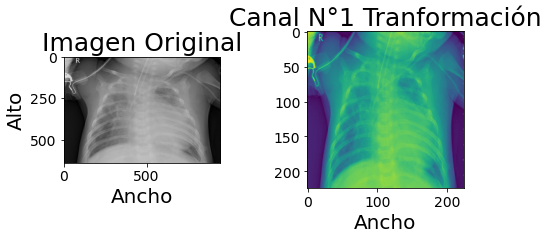

In [76]:
plot_multiple_images_control(im_nem,im_nem_transformed.cpu())
plt.savefig(drive_path + 'imagen_vgg_trans.pdf', format = 'pdf', dpi = 600)

In [77]:
im_nem_transformed = im_nem_transformed.to(device)
pred_image_v = model_VGG16DWSep(im_nem_transformed)
aux_pred_v = np.expand_dims(pred_image_v.cpu().detach().numpy(), axis=0)
aux_pred_v
label_vgg_predict = np.argmax(aux_pred_v[0][0])

In [78]:
im_reboot_vgg = im_nem_transformed.cpu()*torch.tensor(std_transform).view(3,1,1)
im_reboot_vgg = im_reboot_vgg + torch.tensor(mean_transform).view(3,1,1)

im_reboot_vgg = torch_transforms.ToPILImage(mode = 'RGB')(im_reboot_vgg)

In [79]:
slic_vgg =  slic(im_reboot_vgg, n_segments = n_segments) 

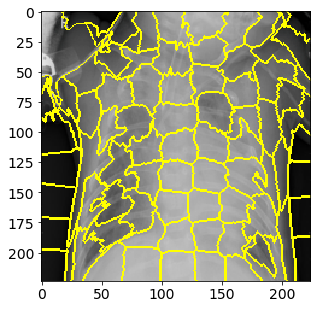

In [80]:
io.imshow(mark_boundaries(im_reboot_vgg, slic_vgg))

In [81]:
n_superpixeles_vgg = len(np.unique(slic_vgg))

In [82]:
# Creamos la matriz de perturbaciones 
matriz_perturbaciones_vgg = bernoulli.rvs(p,size = n_superpixeles_vgg * n_perturbaciones)
# Le damos la forma de matriz, donde cada columna representa un vector de 
# perturbaciones según el número de superpixeles de la imagen
matriz_perturbaciones_vgg = matriz_perturbaciones_vgg.reshape((n_superpixeles_vgg, n_perturbaciones))

In [83]:
vec_images_vgg = Generador_Pert_Images(drive_path + 'neumonia_4.jpeg', n_perturbaciones,
                                          matriz_perturbaciones_vgg,
                                          slic_vgg, n_centercrop_vgg,
                                       f_half_image_transformer_vgg,
                                       s_half_image_transformer_vgg, vgg = True)

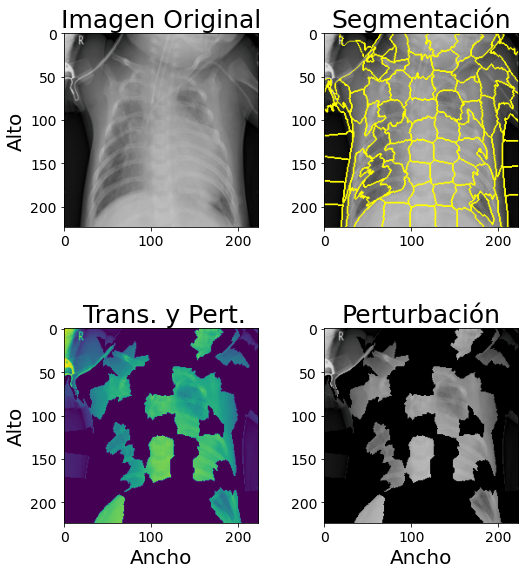

In [84]:
# Visualizamos la imagen segmentada y una perturbacion cualquiera
plot_slic_image_vec(im_reboot_vgg, slic_vgg, vec_images_vgg[0])
plt.savefig(drive_path + 'vgg_pert_seg.pdf', format = 'pdf', dpi = 600)

In [85]:
y_vgg = create_y_vector(label_vgg_predict, model_VGG16DWSep, vec_images_vgg,
                        vgg = True)

In [86]:
pd.Series(y_vgg).value_counts()

1    1372
0     628
dtype: int64

In [87]:
vec_pi_vgg = create_pi_vector(n_superpixeles_vgg, matriz_perturbaciones_vgg)

In [88]:
D_p_vgg = matriz_perturbaciones_vgg.T

              precision    recall  f1-score   support

           0       0.69      0.48      0.56       126
           1       0.79      0.90      0.84       274

    accuracy                           0.77       400
   macro avg       0.74      0.69      0.70       400
weighted avg       0.76      0.77      0.75       400



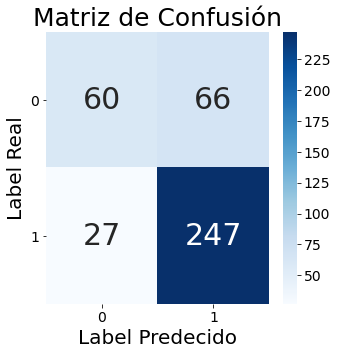

In [89]:
log_vgg= train_and_test_logreg(D_p_vgg, y_vgg, vec_pi_vgg)

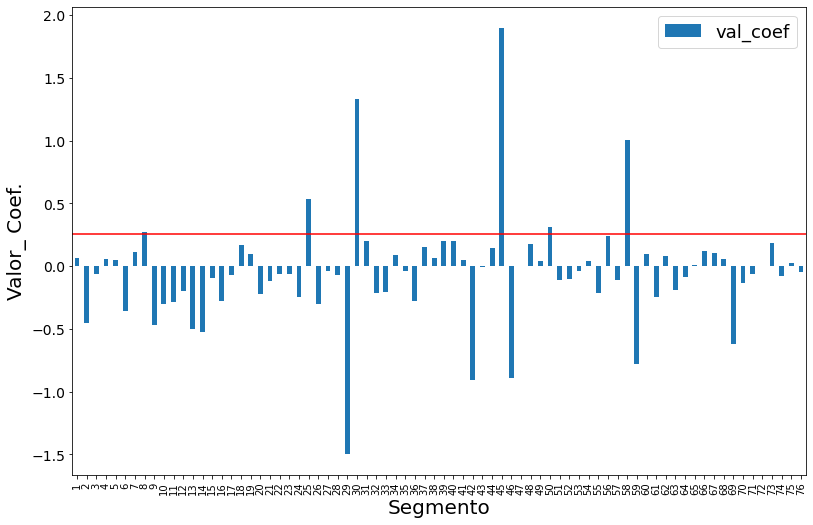

El promedio de los abs de los coeficientes es de 0.26


In [90]:
df_vgg, seg_vgg_image_best, seg_vgg_image_worst = evaluate_coefs(log_vgg.coef_, slic_vgg, to_save = 'coef_vgg',
                                       vgg = True, vgg_image = im_reboot_vgg)

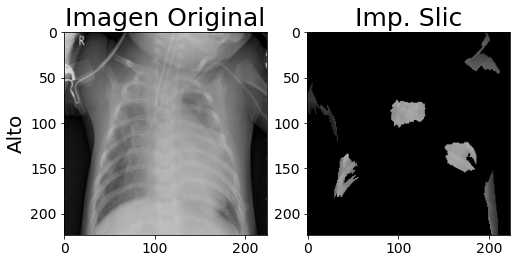

In [91]:
fig, axs = plt.subplots(1,2, figsize = (8,8))
axs[0].imshow(im_reboot_vgg)
axs[0].set_title('Imagen Original')
axs[0].set_ylabel('Alto')

#axs[0,1].imshow(mark_boundaries(image_coef_control, segmented_image))
axs[1].imshow(seg_vgg_image_best)
axs[1].set_title('Imp. Slic')

plt.savefig(drive_path + 'vgg_importantes.pdf', format = 'pdf', dpi = 600)

In [92]:
df_vgg.loc[df_vgg.val_coef >np.mean(abs(df_vgg.val_coef))].shape

(6, 1)

**(Bonus)** Se puede hacer segmentación en el espacio de colores, en este caso, el conjunto a segmentar consiste en una transformación de la imagen de control escalada en un arreglo de dimensión (ancho$\cdot$largo)$\times 3$ (en el caso de ``inception_v3``, la dimesión sería $299^2\times 3$). Sobre este nuevo arreglo implemente un algoritmo de clustering y genere super-píxeles. Aplique un esquema LIME con una familia $G$ no basada en modelos lineales y compare con la misma familia sobre un método de segmentación espacial.

In [59]:
# Se pasa a un array
im_reboot_array = np.array(im_reboot)

# Se crea el dataframe con las indicaciones
# (posición x, posición y, número en escala de grises)
df_X_color = []
for i in range(299):
  for j in range(299):
    df_X_color.append([i, j, *im_reboot_array[i,j]])

df_X_color = np.array(df_X_color)

In [76]:
from sklearn.cluster import KMeans
kmeans_color = KMeans(n_clusters = 14, random_state = 1).fit(df_X_color)

In [77]:
df_X_color_kmeans = np.c_[df_X_color, kmeans_color.labels_]

In [78]:
def slic_model_color(df_X_model, n_centercrop):
  slic_model = np.zeros((n_centercrop,n_centercrop))

  for i in range(n_centercrop*n_centercrop):
      slic_model[df_X_model[i][0]][df_X_model[i][1]] = int(df_X_model[i][5])

  slic_model = slic_model.astype(int)
  return slic_model

slic_kmeans_color = slic_model_color(df_X_color_kmeans, 299)

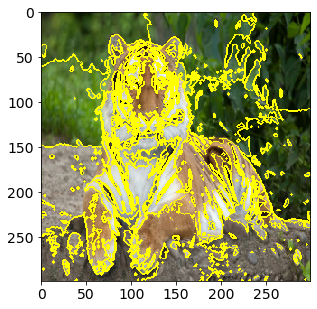

In [79]:
io.imshow(mark_boundaries(im_reboot, slic_kmeans_color))

In [80]:
# Creamos la matriz de perturbaciones 
matriz_perturbaciones_kmeans_color = bernoulli.rvs(p,size = 15 * n_perturbaciones, random_state = 10)
# Le damos la forma de matriz, donde cada columna representa un vector de 
# perturbaciones según el número de superpixeles de la imagen
matriz_perturbaciones_kmeans_color = matriz_perturbaciones_kmeans_color.reshape((15, n_perturbaciones))

In [81]:
vec_images_color_kmeans = Generador_Pert_Images(drive_path + 'tiger_2.jpg', n_perturbaciones,
                                          matriz_perturbaciones_kmeans_color,
                                          slic_kmeans_color, 299,
                                       f_half_image_transformer,
                                       s_half_image_transformer)

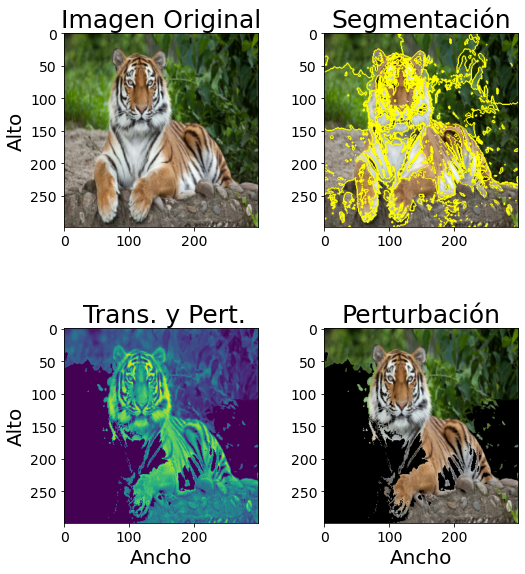

In [82]:
plot_slic_image_vec(im_reboot, slic_kmeans_color, vec_images_color_kmeans[0])

In [83]:
y_color_kmeans = create_y_vector(label_predict[0][0][1], model_inception, vec_images_color_kmeans)

In [84]:
# La cantidad de labels bien catalogados es de
pd.Series(y_color_kmeans).value_counts()

1    1698
0     302
dtype: int64

In [85]:
vec_pi_color_kmeans = create_pi_vector(15, matriz_perturbaciones_kmeans_color)

In [86]:
D_p_kmeans_color = matriz_perturbaciones_kmeans_color.T

In [87]:
import xgboost as xgb

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        60
           1       0.97      0.99      0.98       340

    accuracy                           0.97       400
   macro avg       0.96      0.92      0.94       400
weighted avg       0.97      0.97      0.97       400



Text(20.0, 0.5, 'Label Real')

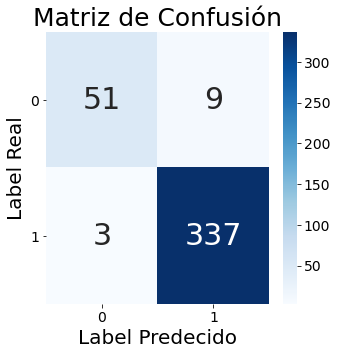

In [88]:
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(D_p_kmeans_color,
                                                    y_color_kmeans,
                                                    vec_pi_color_kmeans,
                                                    shuffle=True,
                                                    test_size = 0.2,
                                                    stratify = y_color_kmeans)

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train, sample_weight = sw_train)
y_pred = xgb_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred) 
classes = unique_labels(y_test, y_pred)

plt.figure(figsize = (5,5))

g = sns.heatmap(pd.DataFrame(cm, index = classes, columns = classes),
                annot=True, fmt = 'd', 
                cmap="Blues")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)

plt.title('Matriz de Confusión')
plt.xlabel('Label Predecido')
plt.ylabel('Label Real')


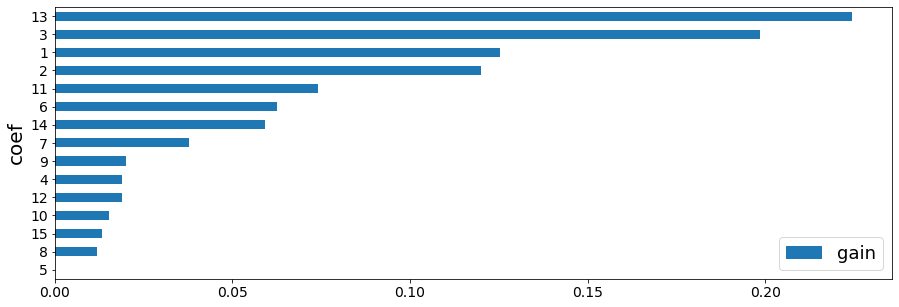

In [89]:
df_xgb = pd.DataFrame({'gain' :xgb_classifier.feature_importances_,
              'coef': range(1,16)}).set_index('coef')

df_xgb.sort_values(by = 'gain').plot(kind = 'barh')

In [101]:
high_xgb = df_xgb.nlargest(4, 'gain').index
image_xgb = np.array(f_half_image_transformer(Image.open(image_path)))
for j in range(image_xgb.shape[0]):
  for k in range(image_xgb.shape[1]):
    n_pix = slic_kmeans_color[j,k]
    if n_pix not in high_xgb:
      image_xgb[j,k] = [0, 0, 0]

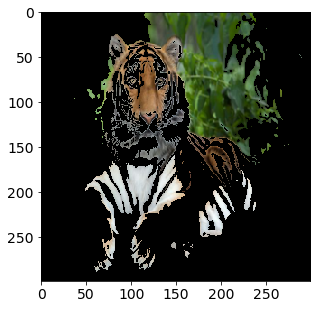

In [102]:
io.imshow(image_xgb)

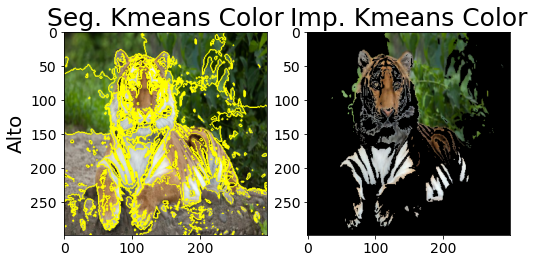

In [103]:
fig, axs = plt.subplots(1,2, figsize = (8,8))
axs[0].imshow(mark_boundaries(im_reboot, slic_kmeans_color))
axs[0].set_title('Seg. Kmeans Color')
axs[0].set_ylabel('Alto')

#axs[0,1].imshow(mark_boundaries(image_coef_control, segmented_image))
axs[1].imshow(image_xgb)
axs[1].set_title('Imp. Kmeans Color')

plt.savefig(drive_path + 'color_kmeans.pdf', format = 'pdf', dpi = 600)